In [40]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install 'DAWG-Python >= 0.7'

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import requests
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1) Парсим

Парсить будем статьи с хабра, там есть теги и хабы, которые мы будем исопльзовтаь ключевые слова.

In [20]:
def get_post(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.text)
  title = soup.find("meta", property="og:title")
  title = str(title).split('="')[1].split('" ')[0]

  post = "\n".join([title] + [el.text for el in soup.find("div", id="post-content-body").find_all("p")])
  keywords = [el.text for el in soup.find_all("li", {"class": "tm-separated-list__item"})]

  return post, keywords

In [21]:
def get_post_len_in_tokens(post):
  return len([item for item in word_tokenize(post) if len(item) > 1 and item.isalpha()])

get_post_len_in_tokens(get_post("https://habr.com/ru/post/700290/")[0])

1527

In [22]:
#посты довольно длинные, так что соберем ссылки на них вручную

urls = ["https://habr.com/ru/post/700290/", 
         "https://habr.com/ru/company/vk/blog/699852/", 
         "https://habr.com/ru/company/sberbank/blog/700266/", 
         "https://habr.com/ru/company/oleg-bunin/blog/699892/", 
         "https://habr.com/ru/company/surfstudio/blog/700018/"]

data = []
labels = []
corpus_token_len = 0

for url in urls:
  post, keywords = get_post(url)
  data.append(post)
  labels.append(keywords)
  corpus_token_len += get_post_len_in_tokens(post)

print(f"Количество текстов: {len(data)}, количество токенов: {corpus_token_len}")

Количество текстов: 5, количество токенов: 8952


## 2) Эталон

In [5]:
handpicked_keywords = ["data scientist,резюме,summary,опыт,написать summary".split(","),
                       "перевод,язык,интерфейс,интернационализация,трудность".split(","),
                       "day offer,java,разработчик,кандидат,собеседование,день".split(","),
                       "devops,конференция,доклад".split(","),
                       "команда,аналитик,команда аналитик,лид".split(","),
]
#так как собиралось вручную, я сразу писала все в нормальной форме и ловеркейсом

In [9]:
def normal_form(word, parser=morph):
  return parser.parse(word)[0].normal_form

def normalize_sent(sent):
  return ' '.join([normal_form(w) for w in word_tokenize(sent.lower()) if w.isalpha() and not w in stop_words])

def normalize_list(l):
  res = [normalize_sent(text) for text in l]
  return [text for text in res if text]

handpicked_keywords = [normalize_list(l) for l in handpicked_keywords]
handpicked_keywords
#проверила себя -- все почти так

[['data scientist', 'резюме', 'summary', 'опыт', 'написать summary'],
 ['перевод', 'язык', 'интерфейс', 'интернационализация', 'трудность'],
 ['day offer', 'java', 'разработчик', 'кандидат', 'собеседование', 'день'],
 ['devops', 'конференция', 'доклад'],
 ['команда', 'аналитик', 'команда аналитик', 'лида']]

In [10]:
labels = [normalize_list(l) for l in labels]
labels

[['summary',
  'resume',
  'cv',
  'career consulting',
  'data scientist career',
  'ml career',
  'ml',
  'dl',
  'управление персонал'],
 ['javascript',
  'фронтенд',
  'frontend',
  'интерфейс',
  'интернационализация',
  'блог компания vk',
  'javascript',
  'интерфейс',
  'локализация продукт'],
 ['управление персонал',
  'конференция',
  'карьера',
  'карьера it',
  'блог компания сбер',
  'управление персонал',
  'карьера',
  'конференция'],
 ['devopsconf',
  'devops',
  'sre',
  'techleads',
  'управление знание',
  'наём it',
  'gitops',
  'kubernetes',
  'сообщество',
  'выступление спикер',
  'блог компания конференция олег бунин онтико',
  'конференция',
  'devops'],
 ['surf',
  'surfstudio',
  'аналитика',
  'работа команда',
  'совет',
  'опыт',
  'разработка мобильный приложение',
  'блог компания surf',
  'анализ проектирование система',
  'аналитика мобильный приложение']]

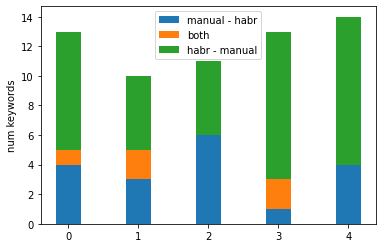

In [11]:
def get_stats(l1, l2):
  s1, s2 = set(l1), set(l2)
  return [len(s1 - s2), len(s1 & s2), len(s2 - s1)]

all_stats = []
for l1, l2 in zip(handpicked_keywords, labels):
  all_stats.append(get_stats(l1, l2))
all_stats = np.array(all_stats)
mh = all_stats[:, 0]
b = all_stats[:, 1]
hm = all_stats[:, 2]

width = 0.35
fig, ax = plt.subplots()

xlables = np.arange(len(data))
ax.bar(xlables, mh, width, label="manual - habr")
ax.bar(xlables, b, width, bottom=mh, label="both")
ax.bar(xlables, hm, width, bottom=mh+b, label="habr - manual")

ax.set_ylabel("num keywords")
ax.legend()

plt.show()
#будем объединять разметки: в моей больше слов, в автоматической больше фраз

In [13]:
true_labels = [list(set(l1) | set(l2)) for l1, l2 in zip(handpicked_keywords, labels)]
true_labels[0]

['опыт',
 'data scientist',
 'резюме',
 'data scientist career',
 'summary',
 'dl',
 'resume',
 'ml career',
 'career consulting',
 'cv',
 'управление персонал',
 'написать summary',
 'ml']

Заодно стоит обработать корпус

In [41]:
def norm_w_punct(text):
  sents = sent_tokenize(text)
  sents = [normalize_sent(s) for s in sents]
  return ". ".join(sents)

norm_data_w_punctuation = [norm_w_punct(text) for text in data]
norm_data_w_punctuation[0][:100]

'summary резюме data scientist автор анна перов. мгу факультет психология магистр. опыт ит рекрутмент'

In [42]:
norm_data = normalize_list(data)

## 3 + 5) Эксперименты, оценка

In [71]:
from nltk.metrics import precision, recall

def get_metrics(l_of_l_true, l_of_l_pred):
  all_p, all_r, all_f1 = [], [], []
  for true, pred in zip(l_of_l_true, l_of_l_pred):
    y_true, y_pred = set(true), set(pred)
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * (p * r) / (p + r) if p+r>0 else 0

    all_p.append(p)
    all_r.append(r)
    all_f1.append(f1)
  return all_p, all_r, all_f1

def visualise_metrics(l_of_l_true, l_of_l_pred):
  res_metrics = get_metrics(l_of_l_true, l_of_l_pred)
  print(f"Mean precision: {np.mean(res_metrics[0])}")
  print(f"Mean recall: {np.mean(res_metrics[1])}")
  print(f"Mean f1 score: {np.mean(res_metrics[0])}")

  metrics = ["precision", "recall", "f1_score"]
  n_docs = len(l_of_l_true)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
  
  for ax, metric, title in zip(axs.flatten(), res_metrics, metrics):
    ax.bar(np.arange(n_docs), metric)
    ax.set_title(title)
  plt.show()

### Rake

In [44]:
!pip3 install python-rake
import RAKE

rake = RAKE.Rake(list(stop_words))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
rake_pred = [[kw for kw, _ in rake.run(text, maxWords=3)] for text in norm_data_w_punctuation]
rake_pred[0]

['понимание ваш опыт',
 'experience yandex google',
 'стоить позвать интервью',
 'это верно резюме',
 'вообще нужно summary',
 'summary резюме',
 'почему именно',
 'хобби достижение',
 'пример основать',
 'попросить оценить',
 'знать уметь',
 'например полезно',
 'область эксперт',
 'нужно',
 'область',
 'многие',
 'кандидат']

Mean precision: 0.022844291580013866
Mean recall: 0.08785214785214786
Mean f1 score: 0.022844291580013866


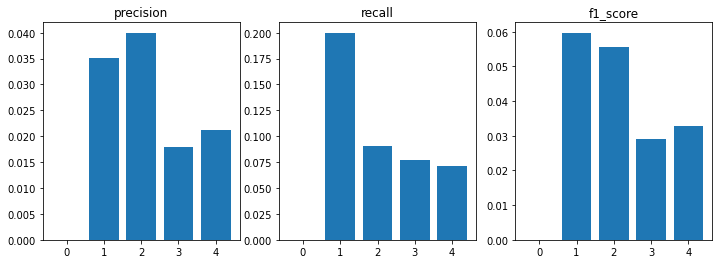

In [72]:
visualise_metrics(true_labels, rake_pred)

### Tf-idf

!!  Как 6 пункт дз
* сразу ошибка и решение: тут не получатся высокие метрики, потому что выделяем только униграммы; можно было бы добавить би- и три-граммы и повысить качество
* и еще -- это очень маленький корпус для того чтобы сделать хороший тфидф



In [79]:
np.argsort([[1,3,2], 
            [3,1,2]], axis=1)[:,:-3:-1]

array([[1, 2],
       [0, 2]])

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
tfidf_data = v.fit_transform(norm_data)
vocab = list(v.vocabulary_.keys())

def get_top_n(tfidf_data, n):
  return np.argsort(tfidf_data.toarray())[:, : -n - 1 : -1]

kw_indices = get_top_n(tfidf_data, 100)
tfidf_pred = [[vocab[wi] for wi in row ] for row in kw_indices]
tfidf_pred[0][:10]

['диплом',
 'вовлекать',
 'клиентский',
 'запоминание',
 'текст',
 'идти',
 'россия',
 'повышаться',
 'in',
 'читать']

Mean precision: 0.01
Mean recall: 0.08433566433566435
Mean f1 score: 0.01


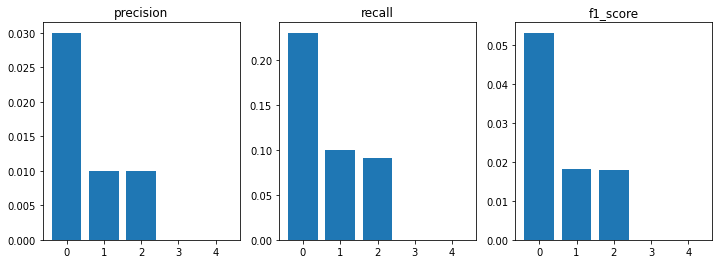

In [97]:
visualise_metrics(true_labels, tfidf_pred)
#и это при довольно большом n

### TextRank

In [98]:
!pip3 install summa
from summa import keywords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54410 sha256=cff0dc1542f30722358324af22a648fd65975f2f47ed98660e3fa734f59a2210
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [101]:
textrank_pred = [keywords.keywords(text, language='russian', scores=False).split("\n") for text in norm_data_w_punctuation]
textrank_pred[0][:10]

['summary резюме data',
 'который',
 'компания',
 'ваш',
 'опыт ит',
 'это',
 'пример',
 'например указать',
 'проект',
 'работа']

Mean precision: 0.014130237691650088
Mean recall: 0.1318081918081918
Mean f1 score: 0.014130237691650088


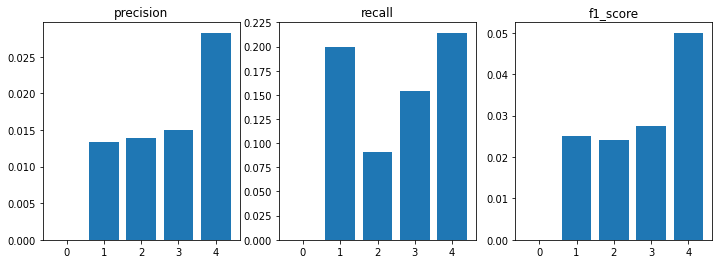

In [103]:
visualise_metrics(true_labels, textrank_pred)
#кажется в ключевых словах рекол важнее, так что это мне нравится

## 4 + 5) шаблоны, оценка

### Подготовка

In [104]:
# проанализируем по кв что нам нужно
key_phrases = []
for doc in true_labels:
  for item in doc:
    if len(item.split()) > 1:
      key_phrases.append(item)
key_phrases

['data scientist',
 'data scientist career',
 'ml career',
 'career consulting',
 'управление персонал',
 'написать summary',
 'блог компания vk',
 'локализация продукт',
 'блог компания сбер',
 'day offer',
 'управление персонал',
 'карьера it',
 'управление знание',
 'выступление спикер',
 'блог компания конференция олег бунин онтико',
 'наём it',
 'аналитика мобильный приложение',
 'анализ проектирование система',
 'команда аналитик',
 'работа команда',
 'блог компания surf',
 'разработка мобильный приложение']

К сожалению у нас тут одни сущ+сущ; !! можно и нужно для точности посмотреть на [сущ + сущ_Род_п], но я не успеваю

Еще много словосочетаний [рус + англ] и [англ + англ], что характерно для тество в IT. Проверим их (и сущ+сущ).

Для упрощения работы рассмотрим только биграммы.


In [163]:
def is_latin(text):
  return bool(re.fullmatch(r"[a-z]*", text))

def is_noun(word, morph=morph):
  parse = morph.parse(word)[0].tag
  return "NOUN" in parse

def eng_eng(w1, w2):
  return is_latin(w1) and is_latin(w2)

#работает так как мы прогоним это на данных где только альфа-строки
def rus_eng(w1, w2):
  return (not is_latin(w1)) and is_latin(w2)

def noun_noun(w1, w2):
  return is_noun(w1) and is_noun(w2)

def pattern_match(w1, w2):
  return eng_eng(w1, w2) or rus_eng(w1, w2) or noun_noun(w1, w2)

def get_patterns_from_text(norm_text):
  tokens = norm_text.split()
  new_tokens = []
  for i in range(len(tokens) - 1):
    if pattern_match(tokens[i], tokens[i+1]):
      new_tokens.append(" ".join([tokens[i], tokens[i+1]]))
  return new_tokens

def get_patterns_in_sents(norm_text_w_punct):
  sents = sent_tokenize(norm_text_w_punct)
  new_sents = []
  for s in sents:
    sent_tokens = get_patterns_from_text(s)
    new_sent = re.sub(r"\b(\w+)\s+\1\b", r"\1", " ".join(sent_tokens)) #убираем дубликаты если у нас последовательность
    new_sents.append(new_sent)
  return ". ".join(new_sents)

patterns_data = [get_patterns_from_text(text) for text in norm_data]
patterns_data_w_punct = [get_patterns_in_sents(text) for text in norm_data_w_punctuation]

#### data

In [164]:
norm_data_w_punctuation[0][:200]

'summary резюме data scientist автор анна перов. мгу факультет психология магистр. опыт ит рекрутмент год samsung ai center huawei. заниматься наём технический специалист samsung ai center нанять huawe'

In [165]:
patterns_data_w_punct[0]

'резюме data scientist автор анна. мгу факультет психология. опыт ит рекрутмент год samsung ai center. специалист samsung ai center нанять huawei ряд команда специалист лидер. год специалист лидер область data science ml dl cv nlp. основатель science tech and ai community ladies in tech and ai community. друг клиент компания faang maang европа азия. клиент обновление резюме развитие карьера сфера ит data science. статья пример успешный summary data scientist шаблон summary резюме шаблон клиент друг стартап россия европа сша компания maang получить job offer amazon google компания инструкция написать summary резюме ответ вопрос summary такой summary. блок резюме. . опыт работа. откликаться summary summary ряд задача ситуация рынок труд поиск работа remote c цель relocation summary роль начало коммуникация обсуждение job. . работа рекрутер компания summary помочь hr лидер команда знание опыт работа уровень зарплата job. образ summary отклик количество отклик фокус. именно summary ответ в

In [166]:
patterns_data[0][:10]

['резюме data',
 'data scientist',
 'автор анна',
 'анна перов',
 'перов мгу',
 'мгу факультет',
 'факультет психология',
 'психология магистр',
 'магистр опыт',
 'опыт ит']

####  target

In [167]:
for kp in key_phrases:
  if len(kp.split()) == 2:
    print(pattern_match(*kp.split()), kp, sep="\t")

True	data scientist
True	ml career
True	career consulting
True	управление персонал
True	написать summary
True	локализация продукт
True	day offer
True	управление персонал
True	карьера it
True	управление знание
True	выступление спикер
True	наём it
True	команда аналитик
True	работа команда


In [173]:
true_key_phrases = [[] for x in range(len(true_labels))]
for i, doc in enumerate(true_labels):
  for item in doc:
    if len(item.split()) == 2 and pattern_match(*item.split()):
      true_key_phrases[i].append(item)
true_key_phrases

[[], [], [], [], []]


[['data scientist',
  'ml career',
  'career consulting',
  'управление персонал',
  'написать summary'],
 ['локализация продукт'],
 ['day offer', 'управление персонал', 'карьера it'],
 ['управление знание', 'выступление спикер', 'наём it'],
 ['команда аналитик', 'работа команда']]

### Rake

In [174]:
rake_pred = [[kw for kw, _ in rake.run(text, maxWords=2)] for text in patterns_data_w_punct]
rake_pred[0]

['блок резюме',
 'опыт работа',
 'experience yandex',
 'компания maang',
 'рекрутер google',
 'экспертиза время',
 'часто summary',
 'summary']

Mean precision: 0.008928571428571428
Mean recall: 0.16666666666666666
Mean f1 score: 0.008928571428571428


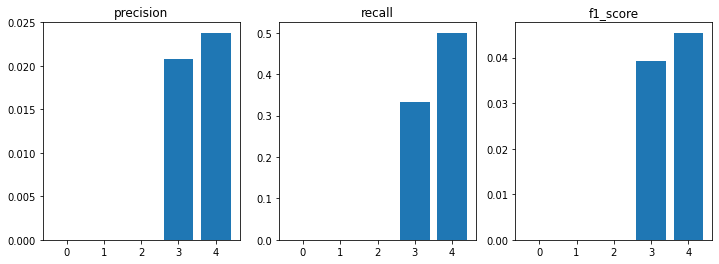

In [175]:
visualise_metrics(true_key_phrases, rake_pred)
#  по качеству лучше не стало, но мне нравится больше

### Tf-idf

In [176]:
v = TfidfVectorizer(ngram_range = (2,2))
tfidf_data = v.fit_transform(patterns_data_w_punct)
vocab = list(v.vocabulary_.keys())

def get_top_n(tfidf_data, n):
  return np.argsort(tfidf_data.toarray())[:, : -n - 1 : -1]

kw_indices = get_top_n(tfidf_data, 100)
tfidf_pred = [[vocab[wi] for wi in row ] for row in kw_indices]
tfidf_pred[0][:10]

['компания написание',
 'summary data',
 'задача ситуация',
 'год это',
 'programming experience',
 'год количество',
 'of programming',
 'has years',
 'вид спорт',
 'жизнь вид']

Mean precision: 0.002
Mean recall: 0.04
Mean f1 score: 0.002


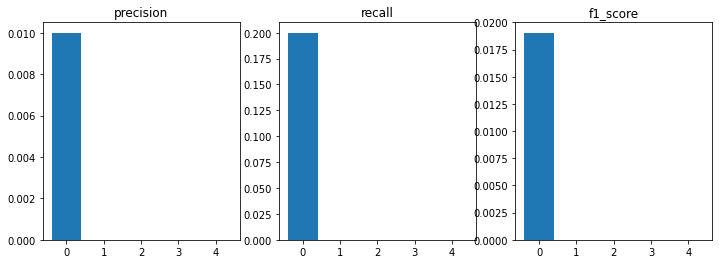

In [178]:
visualise_metrics(true_key_phrases, tfidf_pred)

### Text Rank

In [179]:
textrank_pred = [keywords.keywords(text, language='russian', scores=False).split("\n") for text in patterns_data_w_punct]
textrank_pred[0][:10]

['summary',
 'опыт ит',
 'nlp',
 'клиент компания',
 'работа',
 'область',
 'in',
 'резюме data scientist',
 'пример',
 'год']

Mean precision: 0.0058823529411764705
Mean recall: 0.06666666666666667
Mean f1 score: 0.0058823529411764705


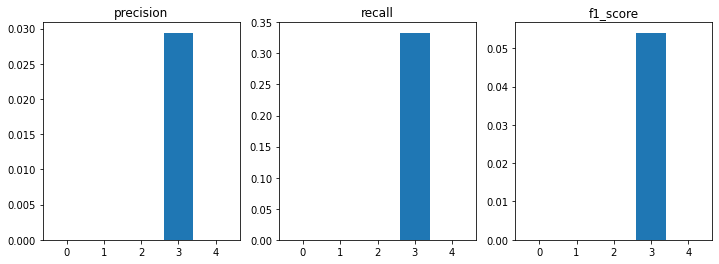

In [181]:
visualise_metrics(true_key_phrases, textrank_pred)
#кажется в ключевых словах рекол важнее, так что это мне нравится

## 6) Ошибки

*   непонятно, как работать с иностранными словами. Отдельно обрабатывать их морфологию? или добавить новый морфологический класс "foreign"?
* на экспериментах с шаблонами качество хуже, потому что находятся лишние униграммы, но мне понравились глазами результаты
*   Тэги и хабы не самая удачная основа для ключевых слов, потому что в итоге оказывается, что не все они вообще есть в тексте

